In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE, load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss_pixel, VAE_loss_rgb
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE
from core.fisher_utils_VAE import AUTO_VAE_CIFAR, AUTO_VAE_FMNIST
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW
from core.fisher_utils_GLOW import AUTO_GLOW_CIFAR, AUTO_GLOW_FMNIST
from core.visualize import plot_hist, AUROC

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'VAE': {'cifar10': {}, 'fmnist': {}},
           'GLOW': {'cifar10': {}, 'fmnist': {}}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'VAE': {'cifar10': {}, 'fmnist': {}},
             'GLOW': {'cifar10': {}, 'fmnist': {}}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'VAE': {'cifar10': {}, 'fmnist': {}},
          'GLOW': {'cifar10': {}, 'fmnist': {}}}

## Note

dictionary 형태로 결괏값을 저장합니다.   
key의 형태는 model - in-dist - out-dist 입니다.  
(ex)  
FISHERs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Fisher Inverse matrix
NORM_FACs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Normalize_Factor  
SCOREs['VAE']['cifar10']['svhn'] : VAE모델, cifar10 (In), svhn (Out) 시 score  

# VAE-CIFAR10

In [3]:
train_dist = 'cifar10'
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=train_dist, ngf=64, nz=200, beta=1)

#params = ['mu'] # for this choice, you must change the architecture of VAE (go core/train_VAE/DCGAN_VAE_pixel.py line 42)
#params = [netE.conv1.weight, netG.main[0].weight, netG.main[-1].weight]
#params_name = ['Econv1', 'Gmain0', 'Gmain-1'] # to assign json filename properly

# See all params
params = {
    'Emain0_w': netE.main[0].weight,
    'Emain1_w': netE.main[1].weight,
    'Emain1_b': netE.main[1].bias,
    'Emain3_w': netE.main[3].weight,
    'Emain4_w': netE.main[4].weight,
    'Emain4_b': netE.main[4].bias,
    'Emain6_w': netE.main[6].weight,
    'Emain7_w': netE.main[7].weight,
    'Emain7_b': netE.main[7].bias,
    'Econv1_w': netE.conv1.weight,
    'Econv1_b': netE.conv1.bias,
    'Econv2_w': netE.conv2.weight,
    'Econv2_b': netE.conv2.bias,
    'Gmain0_w': netG.main[0].weight,
    'Gmain1_w': netG.main[1].weight,
    'Gmain1_b': netG.main[1].bias,
    'Gmain3_w': netG.main[3].weight,
    'Gmain4_w': netG.main[4].weight,
    'Gmain4_b': netG.main[4].bias,
    'Gmain6_w': netG.main[6].weight,
    'Gmain7_w': netG.main[7].weight,
    'Gmain7_b': netG.main[7].bias,
    'Gmain9_w': netG.main[9].weight,
}


In [4]:
a, b, _scores = AUTO_VAE_CIFAR(netE, netG, params, max_iter=[1000, 500], loss_type='ELBO_pixel', method='Vanilla')
#a, b, _scores = AUTO_VAE_CIFAR(netE, netG, params, max_iter=[5000, 5000], loss_type='ELBO_pixel', method='SMW')

Files already downloaded and verified


Calculate Fisher VAE:   2%|█                                                     | 999/50000 [00:11<09:37, 84.78step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                    | 499/10000 [00:06<02:10, 72.86step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE:  17%|█████████▎                                              | 499/3000 [00:06<00:32, 76.73step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                    | 499/10000 [00:06<01:56, 81.71step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                    | 499/10000 [00:05<01:39, 95.59step/s]


In [5]:
for pname in params.keys():
    FISHERs['VAE'][train_dist][pname] = a[pname] 
    NORM_FACs['VAE'][train_dist][pname] = b[pname]
    for ood in opt.ood_list:
        try:
            SCOREs['VAE'][train_dist][ood][pname] = _scores[ood][pname]
        except:
            SCOREs['VAE'][train_dist][ood] = {}
            SCOREs['VAE'][train_dist][ood][pname] = _scores[ood][pname]

In [6]:
# Histogram
#temp = opt.ood_list.copy()
#temp.remove('noise') # 'noise' makes the Histogram too dirty...
#args = [SCOREs['VAE'][train_dist][ood] for ood in temp]
#bins = [100 for _ in temp]
#plot_hist(*args, bins=bins, labels=temp, xlim=[0, 10000])


# AUROC curve
auroc = {}
for pname in params.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs['VAE'][train_dist][train_dist][pname],
            SCOREs['VAE'][train_dist][ood][pname],
        ]
        labels = [train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[pname] = _auroc
   

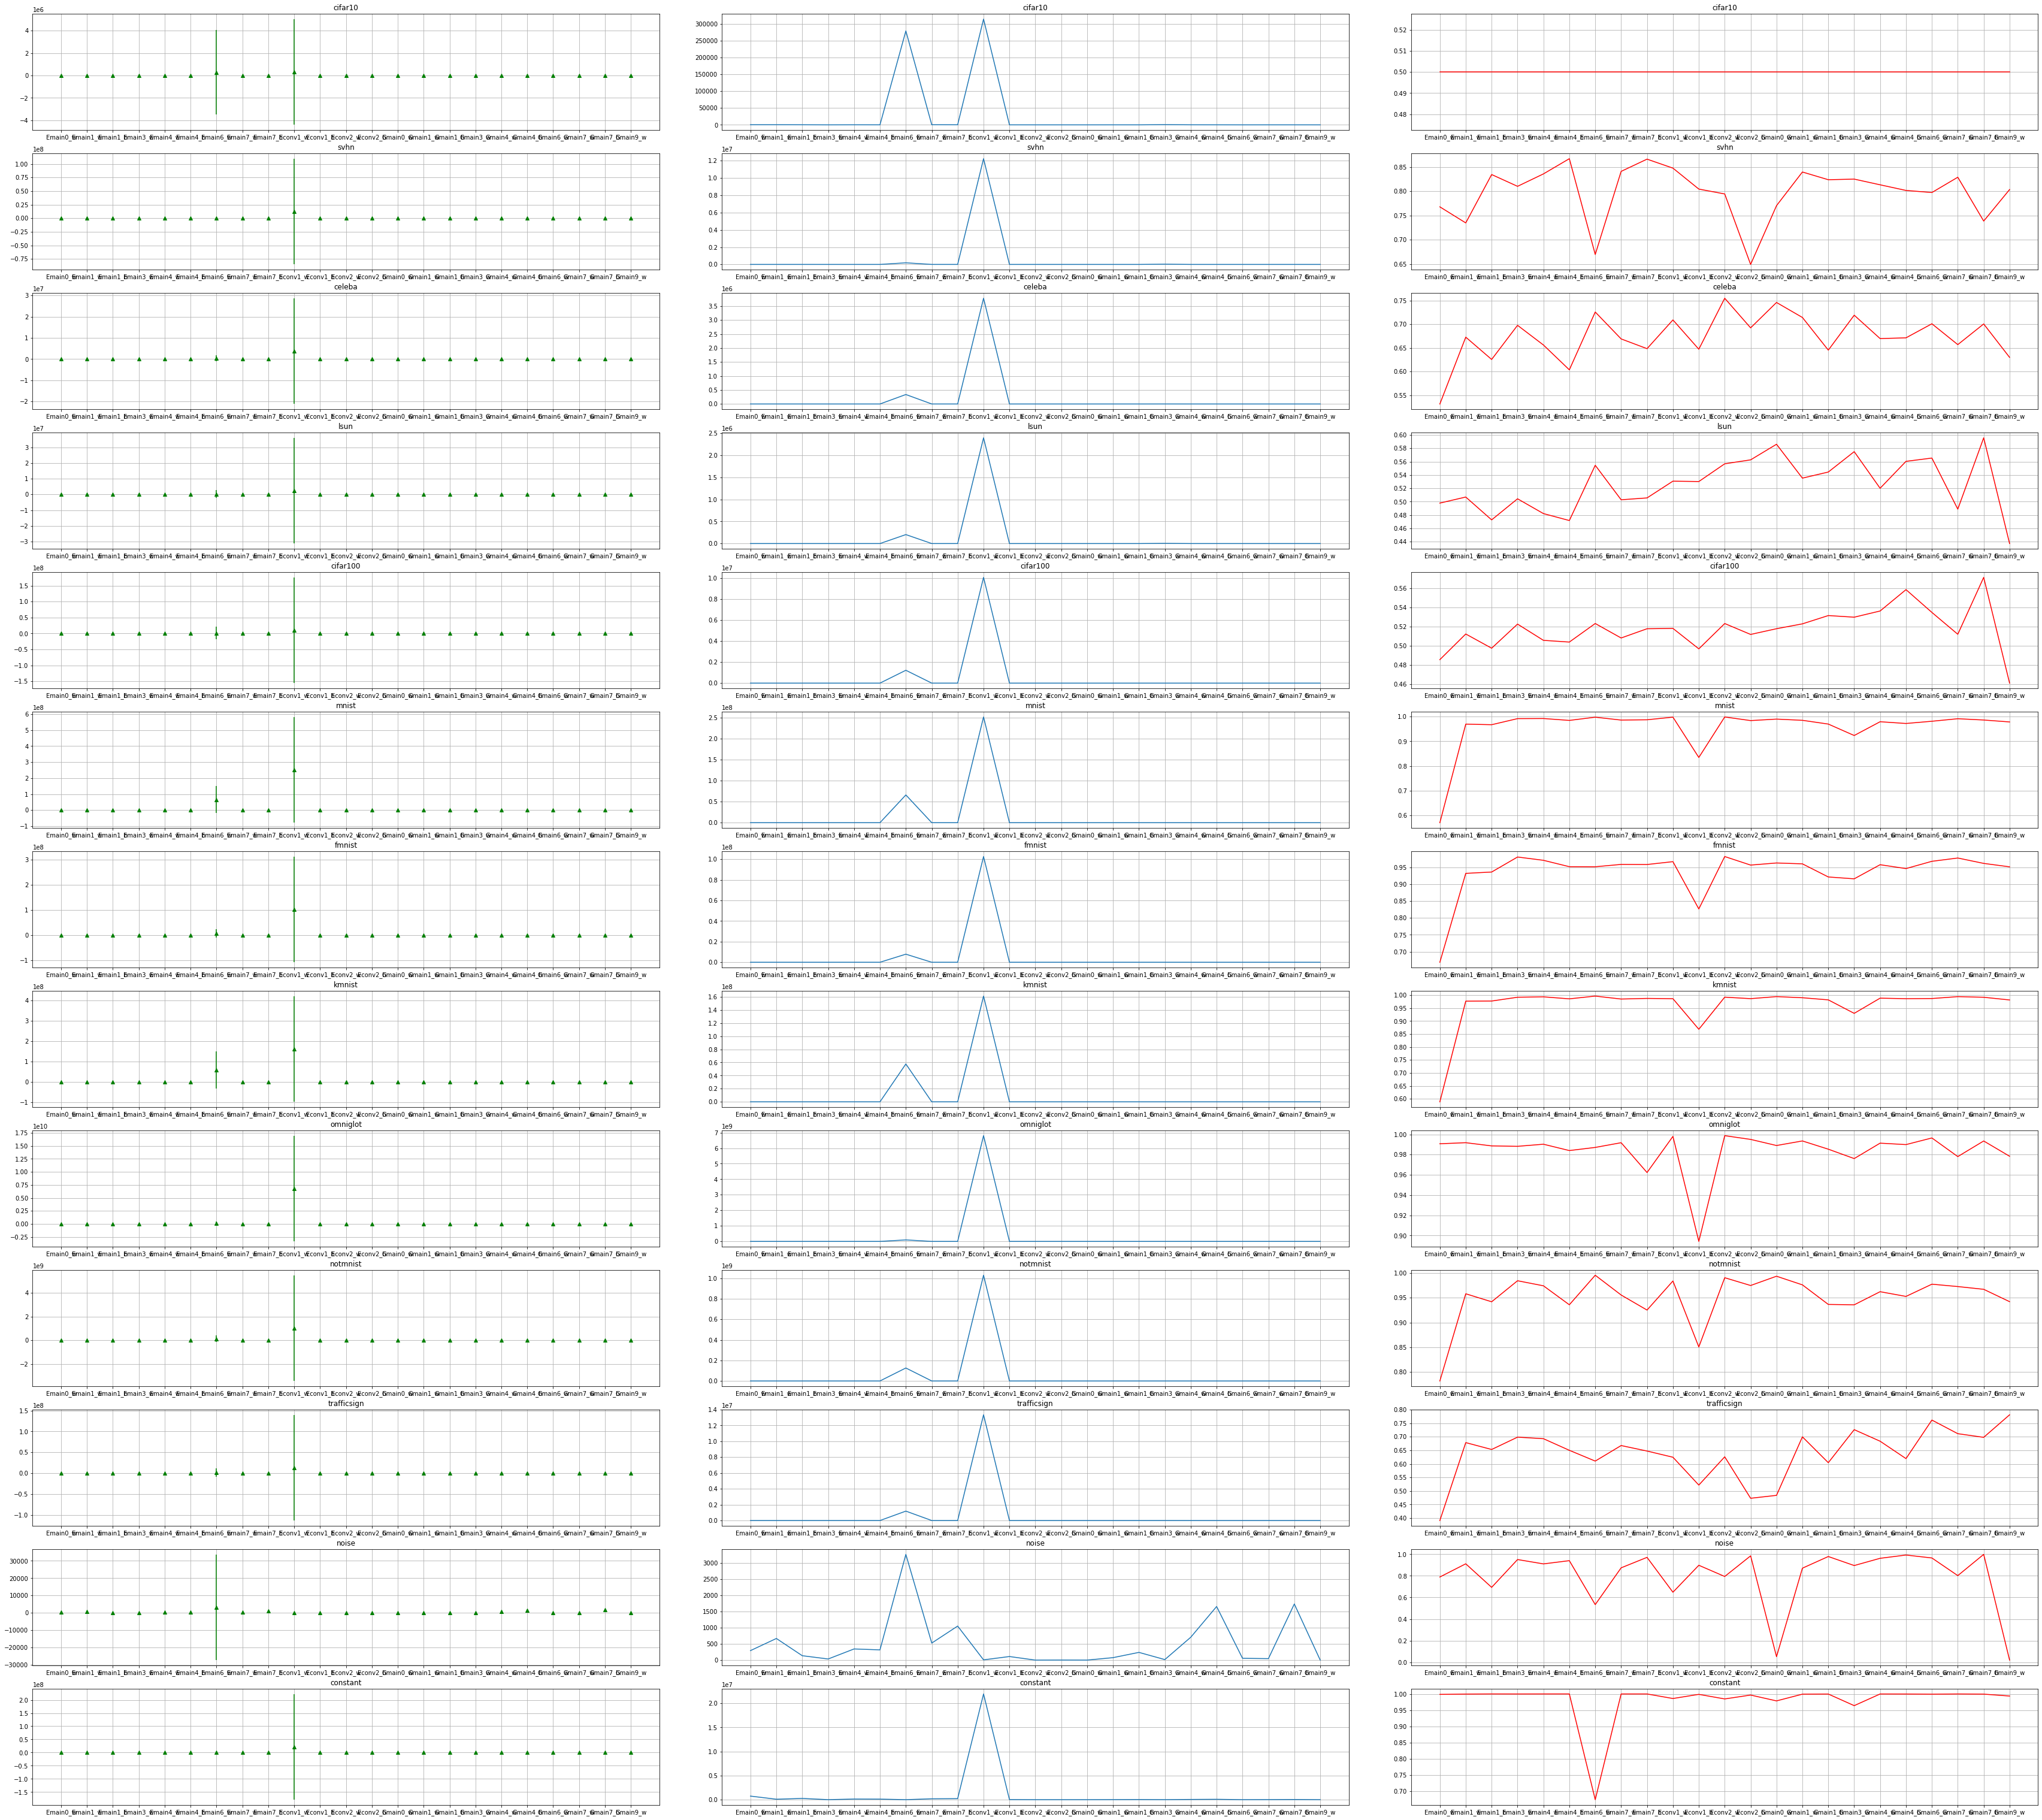

In [7]:
# Just show scores
fig = plt.figure(figsize=(60, 55))
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.2)
for i, ood in enumerate(opt.ood_list):
    df = pd.DataFrame(SCOREs['VAE'][train_dist][ood])
    df.loc['mean', :] = df.mean()
    df.loc['std', :] = df.std()
    ax = fig.add_subplot(len(opt.ood_list), 3, 3*i+1)
    ax.set_title(f'{ood}')
    ax.errorbar(df.columns, df.loc['mean', :], df.loc['std', :], linestyle='None', marker='^', color='g')
    ax.grid()
for i, ood in enumerate(opt.ood_list):
    df = pd.DataFrame(SCOREs['VAE'][train_dist][ood])
    df.loc['mean', :] = df.mean()
    df.loc['std', :] = df.std()
    ax = fig.add_subplot(len(opt.ood_list), 3, 3*i+2)
    ax.set_title(f'{ood}')
    ax.plot(df.columns, df.loc['mean', :])
    ax.grid()
df = pd.DataFrame(auroc)
for i, ood in enumerate(opt.ood_list):
    ax = fig.add_subplot(len(opt.ood_list), 3, 3*i+3)
    ax.set_title(f'{ood}')
    ax.plot(df.columns, df.loc[ood, :], color='r')
    ax.grid()

fig.savefig('./score_mean_std_auroc.png')
    

In [120]:
netE, netG

(Encoder(
   (conv1): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
   (conv2): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
   (main): Sequential(
     (input-conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (input-BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (input-relu): ReLU(inplace=True)
     (pyramid:64-128:conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (pyramid:128:relu): ReLU(inplace=True)
     (pyramid:128-256:conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (pyramid:256:relu): ReLU(inplace=True)
   )
 ),
 DCGAN_G(
   (main): Sequential(
     (initial:200-256:convt): ConvTransp

# VAE-FMNIST

In [49]:
train_dist = 'fmnist'
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=train_dist, ngf=64, nz=100, beta=1)

#dicts = [netG.main[-1].weight, netE.conv1.weight]
dicts = [netE.conv1.weight]
#dicts = ['mu']

In [50]:
a, b, _scores = AUTO_VAE_FMNIST(netE, netG, dicts, max_iter=[3000, 1000], loss_type='ELBO')

Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:07<01:11, 126.44step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE: 100%|████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 115.69step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:08<01:19, 113.80step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:07<01:11, 126.50step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:06<01:02, 144.30step/s]


In [51]:
FISHERs['VAE']['fmnist'] = a[dicts[0]]
NORM_FACs['VAE']['fmnist'] = b[dicts[0]]
for ood in opt.ood_list:
    SCOREs['VAE']['fmnist'][ood] = _scores[ood][dicts[0]]

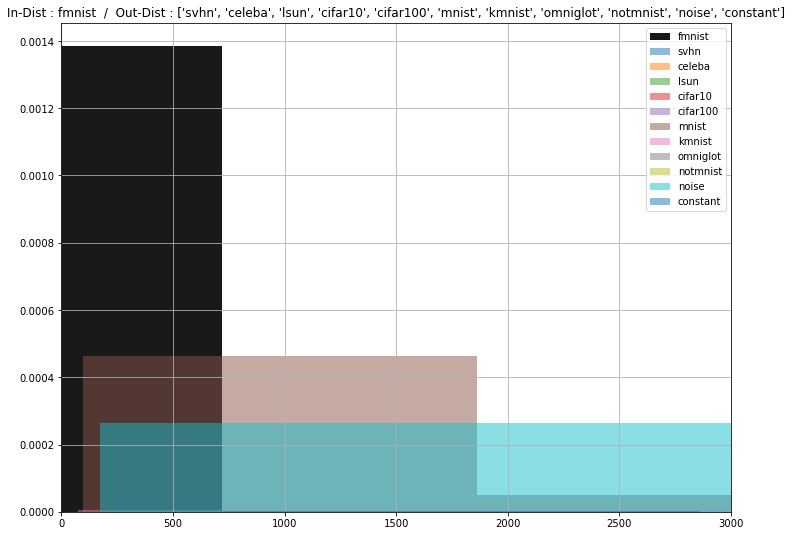

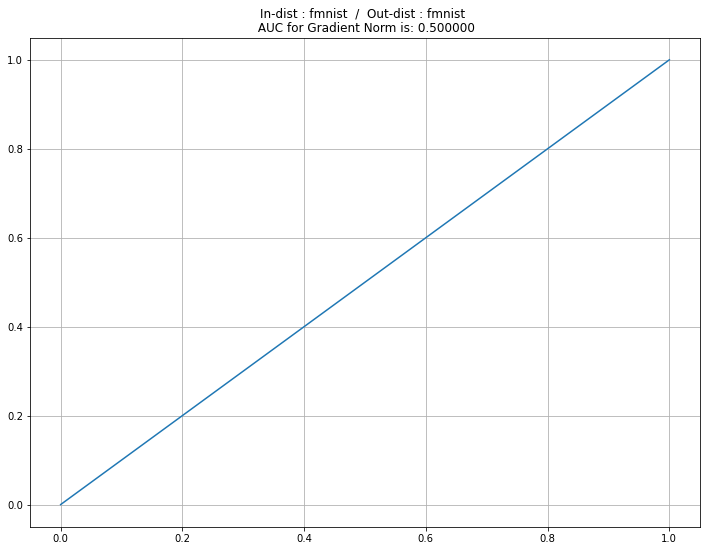

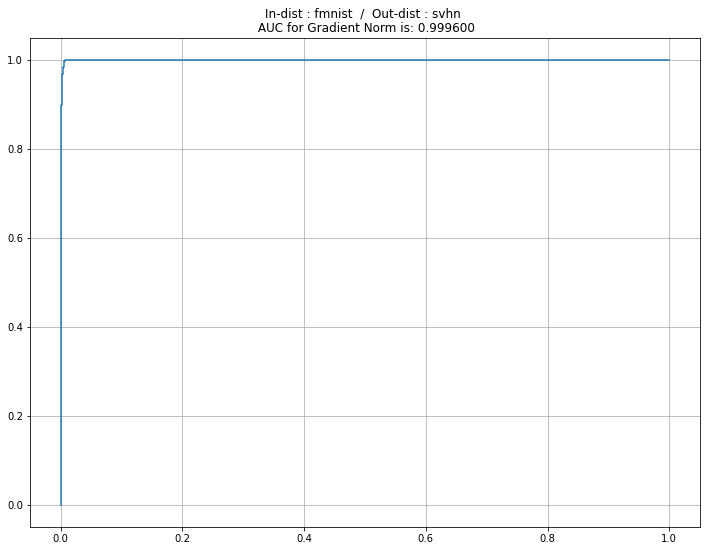

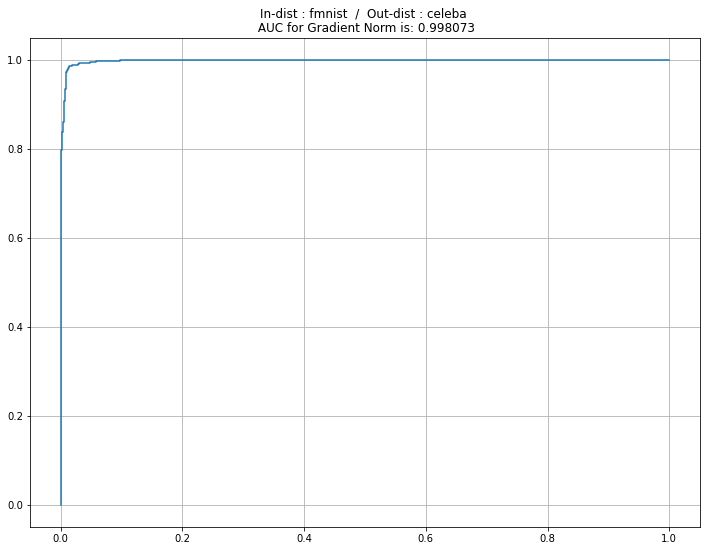

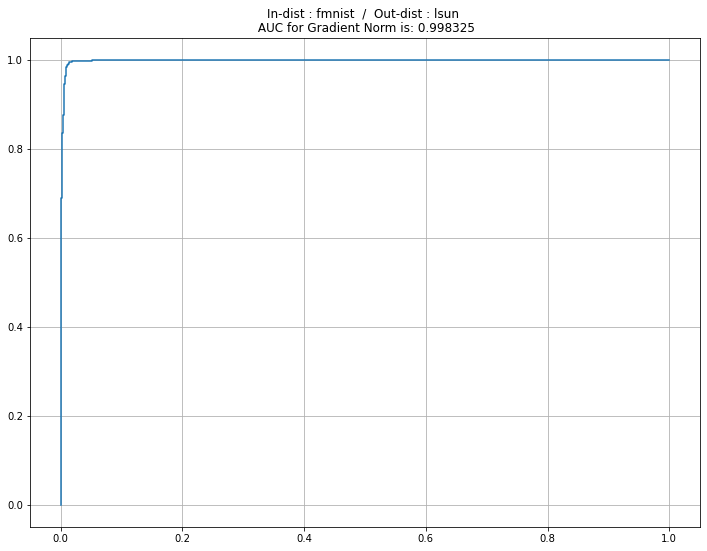

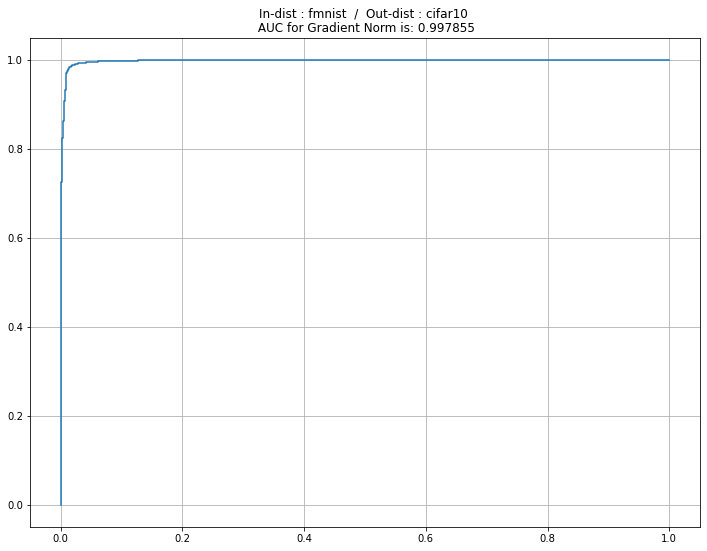

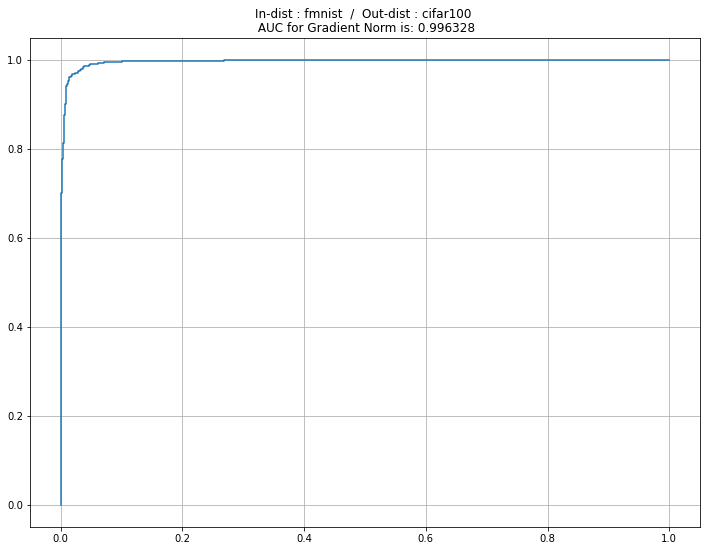

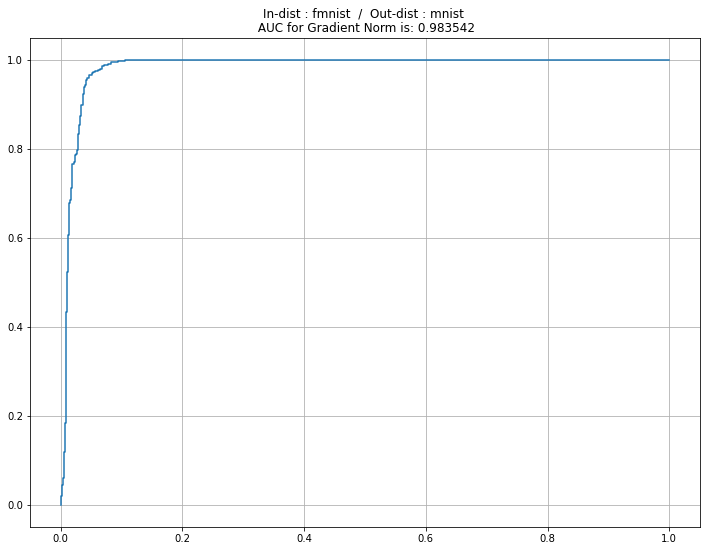

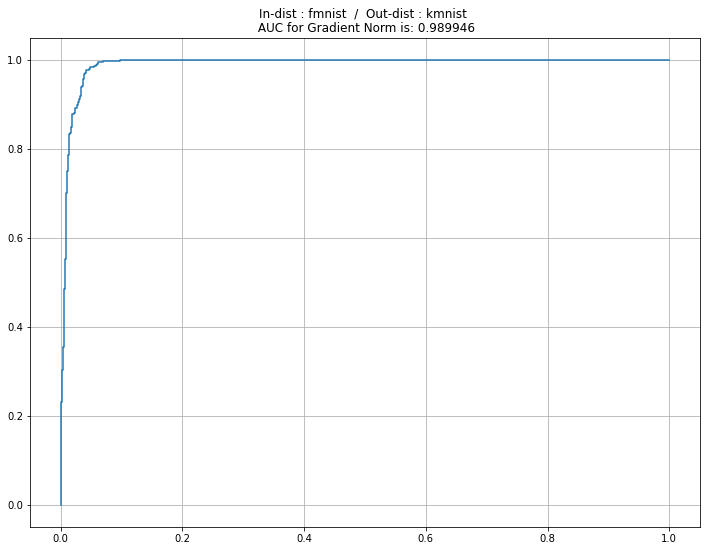

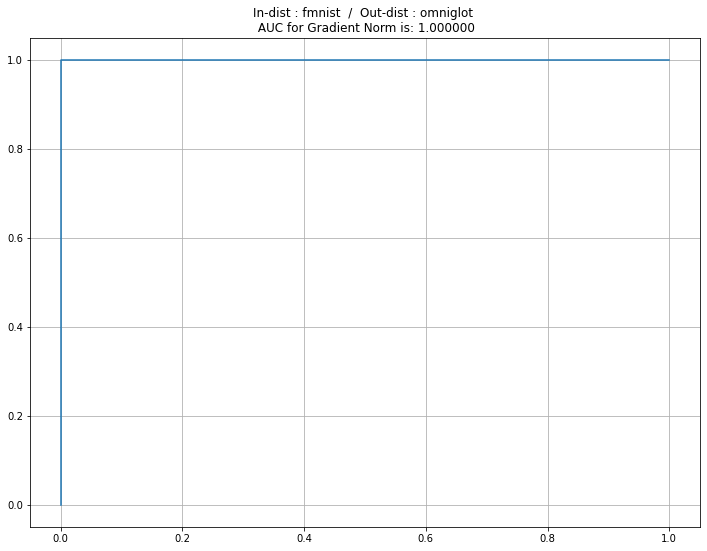

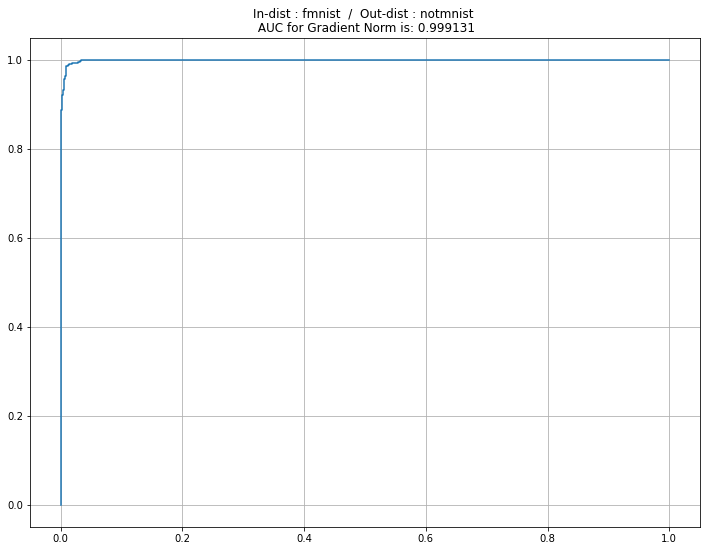

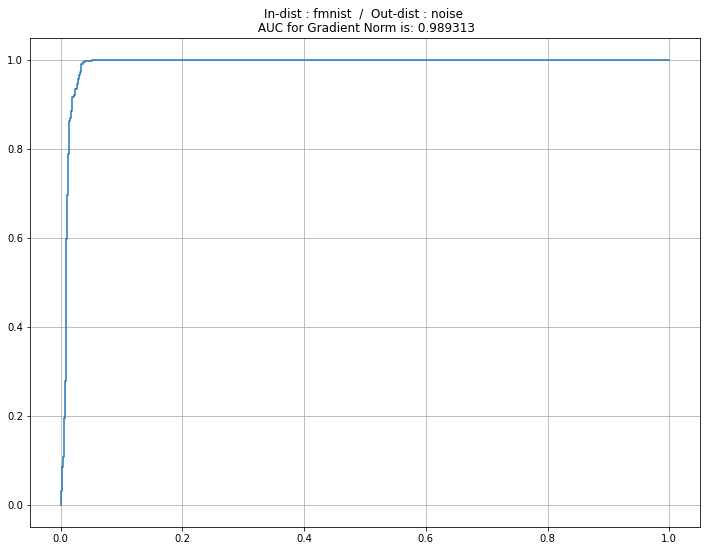

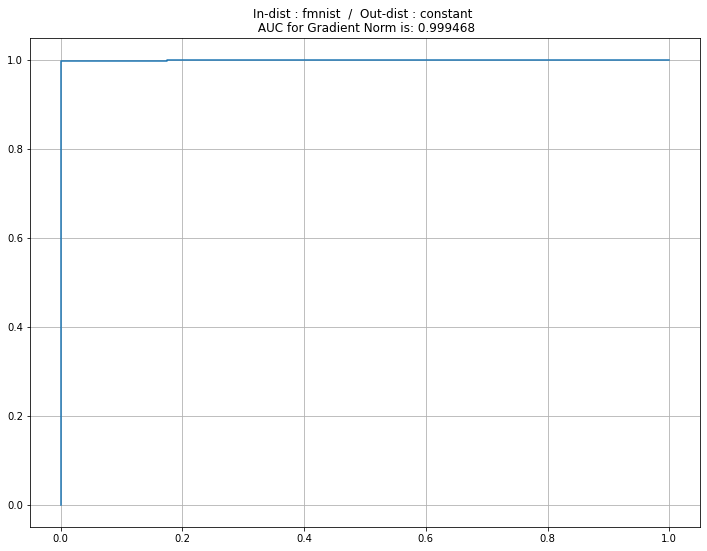

In [52]:
# Histogram
args = [SCOREs['VAE']['fmnist'][ood] for ood in opt.ood_list]
bins = [100 for _ in opt.ood_list]
plot_hist(*args, bins=bins, labels=opt.ood_list, xlim=[0, 3000])


# AUROC curve
for ood in opt.ood_list:
    args = [
        SCOREs['VAE']['fmnist']['fmnist'],
        SCOREs['VAE']['fmnist'][ood],
    ]
    labels = ['fmnist', ood]
    AUROC(*args, labels=labels)

# GLOW-CIFAR10

In [160]:
train_dist = 'cifar10'
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=train_dist)

dicts = [model.flow.layers[-1]]

In [161]:
a, b, c, d, e, f, g = AUTO_GLOW_CIFAR(model, dicts)
GRADs['GLOW']['cifar10'] = a
NORM_FACs['GLOW']['cifar10'] = b
Gradients['GLOW']['cifar10']['cifar10'] = c
Gradients['GLOW']['cifar10']['svhn'] = d
Gradients['GLOW']['cifar10']['celeba'] = e
Gradients['GLOW']['cifar10']['lsun'] = f
Gradients['GLOW']['cifar10']['noise'] = g

Files already downloaded and verified


Calculate Fisher GLOW:   2%|█                                                 | 1001/50000 [04:28<3:38:56,  3.73step/s]


Files already downloaded and verified


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:48<43:22,  3.69step/s]


Using downloaded and verified file: ../data/test_32x32.mat


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:46<42:33,  3.76step/s]


In [12]:
# Histogram
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
    Gradients['GLOW']['cifar10']['celeba'],
    Gradients['GLOW']['cifar10']['lsun'],
    Gradients['GLOW']['cifar10']['noise'],
]
bins = [100, 100, 100, 100, 100]
labels = ['cifar10', 'svhn', 'celeba', 'lsun', 'noise']
xlim = [0, 2]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
]
labels = ['cifar', 'svhn']
AUROC(*args, labels=labels)

KeyError: 'cifar10'

# GLOW-FMNIST (미완성)

In [ ]:
train_dist = 'fmnist'
opt = config.GLOW_fmnist # 에러날 거
netE, netG = load_pretrained_VAE(option=train_dist)

dicts = [netG.main[-1].weight, netE.conv1.weight]

In [ ]:
a, b, c, d, e = AUTO_GLOW_FNNIST(netE, netG, dicts)
GRADs['GLOW']['fmnist'] = a
NORM_FACs['GLOW']['fmnist'] = b
Gradients['GLOW']['fmnist']['fmnist'] = c
Gradients['GLOW']['fmnist']['mnist'] = d
Gradients['GLOW']['fmnist']['noise'] = e

In [ ]:
# Histogram
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
    Gradients['GLOW']['fmnist']['noise'],
]
bins = [100, 100, 100]
labels = ['fmnist', 'mnnist', 'noise']
xlim = [0, 5]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
]
labels = ['fmnist', 'mnist']
AUROC(*args, labels=labels)